# Batting Advanced Modeling

In [187]:
# import libraries 
import pandas as pd
import numpy as np
import math
from scipy.stats import kurtosis, skew

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import r2_score, mean_squared_error

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline

# this will allow us to visualize the pipeline (may not be available in learn-env)
from sklearn import set_config
set_config(display= 'diagram')

from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, \
RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
AdaBoostClassifier, GradientBoostingClassifier

from pickle import dump, load

# ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)

np.random_state = 42

In [188]:
# load 
batting_adv = pd.read_csv('Data/batting_adv', index_col = 0)
batting_adv = batting_adv.drop(columns = ['Season', 'Name', 'POS', 'Team', 'Dol', 'Age Rng'])
batting_adv

,Age,Salary,Adjusted 2021 Salary,G,AB,PA,H,1B,2B,3B,HR,R,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,AVG,GB,FB,LD,IFFB,Pitches,Balls,Strikes,IFH,BU,BUH,BB%,K%,BB/K,OBP,SLG,OPS,ISO,BABIP,GB/FB,LD%,GB%,FB%,IFFB%,HR/FB,IFH%,BUH%,wOBA,wRAA,wRC,Bat,Fld,Rep,Pos,RAR,WAR,Spd,wRC+,WPA,-WPA,+WPA,RE24,REW,pLI,phLI,PH,WPA/LI,Clutch,FB% (Pitch),FBv,SL%,SLv,CT%,CTv,CB%,CBv,CH%,CHv,SF%,SFv,KN%,KNv,XX%,PO%,wFB,wSL,wCT,wCB,wCH,wSF,wKN,wFB/C,wSL/C,wCT/C,wCB/C,wCH/C,wSF/C,wKN/C,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,F-Strike%,SwStr%,BsR,FA% (sc),FT% (sc),FC% (sc),FS% (sc),FO% (sc),SI% (sc),SL% (sc),CU% (sc),KC% (sc),EP% (sc),CH% (sc),SC% (sc),KN% (sc),UN% (sc),vFA (sc),vFT (sc),vFC (sc),vFS (sc),vFO (sc),vSI (sc),vSL (sc),vCU (sc),vKC (sc),vEP (sc),vCH (sc),vSC (sc),vKN (sc),FA-X (sc),FT-X (sc),FC-X (sc),FS-X (sc),FO-X (sc),SI-X (sc),SL-X (sc),CU-X (sc),KC-X (sc),EP-X (sc),CH-X (sc),SC-X (sc),KN-X (sc),FA-Z (sc),FT-Z (sc),FC-Z (sc),FS-Z (sc),FO-Z (sc),SI-Z (sc),SL-Z (sc),CU-Z (sc),KC-Z (sc),EP-Z (sc),CH-Z (sc),SC-Z (sc),KN-Z (sc),wFA (sc),wFT (sc),wFC (sc),wFS (sc),wFO (sc),wSI (sc),wSL (sc),wCU (sc),wKC (sc),wEP (sc),wCH (sc),wSC (sc),wKN (sc),wFA/C (sc),wFT/C (sc),wFC/C (sc),wFS/C (sc),wFO/C (sc),wSI/C (sc),wSL/C (sc),wCU/C (sc),wKC/C (sc),wEP/C (sc),wCH/C (sc),wSC/C (sc),wKN/C (sc),O-Swing% (sc),Z-Swing% (sc),Swing% (sc),O-Contact% (sc),Z-Contact% (sc),Contact% (sc),Zone% (sc),Pace,Def,wSB,UBR,Off,Lg,wGDP,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%,TTO%,CH% (pi),CS% (pi),CU% (pi),FA% (pi),FC% (pi),FS% (pi),KN% (pi),SB% (pi),SI% (pi),SL% (pi),XX% (pi),vCH (pi),vCS (pi),vCU (pi),vFA (pi),vFC (pi),vFS (pi),vKN (pi),vSB (pi),vSI (pi),vSL (pi),vXX (pi),CH-X (pi),CS-X (pi),CU-X (pi),FA-X (pi),FC-X (pi),FS-X (pi),KN-X (pi),SB-X (pi),SI-X (pi),SL-X (pi),XX-X (pi),CH-Z (pi),CS-Z (pi),CU-Z (pi),FA-Z (pi),FC-Z (pi),FS-Z (pi),KN-Z (pi),SB-Z (pi),SI-Z (pi),SL-Z (pi),XX-Z (pi),wCH (pi),wCS (pi),wCU (pi),wFA (pi),wFC (pi),wFS (pi),wKN (pi),wSB (pi),wSI (pi),wSL (pi),wXX (pi),wCH/C (pi),wCS/C (pi),wCU/C (pi),wFA/C (pi),wFC/C (pi),wFS/C (pi),wKN/C (pi),wSB/C (pi),wSI/C (pi),wSL/C (pi),wXX/C (pi),O-Swing% (pi),Z-Swing% (pi),Swing% (pi),O-Contact% (pi),Z-Contact% (pi),Contact% (pi),Zone% (pi),Pace (pi),FRM,AVG+,BB%+,K%+,OBP+,SLG+,ISO+,BABIP+,LD+%,GB%+,FB%+,HR/FB%+,Pull%+,Cent%+,Oppo%+,Soft%+,Med%+,Hard%+,EV,LA,Barrels,Barrel%,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA
0,40.0,9000000.0,10029411.0,78.0,133.0,155.0,33.0,23.0,9.0,0.0,1.0,12.0,14.0,20.0,0.0,21.0,0.0,2.0,0.0,3.0,1.0,0.0,0.248,56.0,33.0,25.0,0.0,647.0,260.0,387.0,0.0,0.0,0.0,0.129,0.135,0.95,0.342,0.338,0.680,0.090,0.283,0.0170,0.219,0.491,0.289,0.000,0.030,0.000,0.00,0.309,-0.1,17.0,0.0,-4.7,4.4,-1.4,-2.0,-0.2,2.4,100.0,0.23,-3.06,3.28,2.82,0.36,1.26,1.60,43.0,0.26,-0.08,0.637,92.5,0.099,83.8,0.053,88.1,0.079,78.0,0.124,83.7,0.009,87.2,0.000,0.0,0.000,0.0,2.0,-0.1,-0.1,-0.3,-1.2,-0.1,0.0,0.49,-0.13,-0.35,-0.52,-1.45,-0.96,0.00,0.254,0.546,0.377,0.653,0.919,0.816,0.422,0.613,0.070,-0.6,0.321,0.151,0.036,0.017,0.000,0.172,0.125,0.045,0.023,0.002,0.108,0.000,0.000,0.0,93.1,92.1,89.4,86.5,0.0,91.6,83.7,77.2,80.1,64.8,83.0,0.0,0.0,-3.2,-7.3,1.5,-5.4,0.0,-7.0,2.4,4.8,5.9,6.1,-7.2,0.0,0.0,8.0,5.2,5.5,2.5,0.0,4.5,-0.2,-7.4,-8.5,-12.6,3.3,0.0,0.0,-1.2,2.2,-0.7,-0.3,0.0,1.1,0.5,-1.1,0.3,-0.1,-0.5,0.0,0.0,-0.56,2.20,-2.95,-3.06,0.00,1.03,0.60,-3.63,1.79,-5.40,-0.76,0.00,0.00,0.235,0.534,0.377,0.588,0.927,0.816,0.474,25.8,-6.1,0.0,-0.5,-0.6,0.3,-0.1,0.377,0.342,0.281,0.105,0.614,0.281,0.271,0.097,0.002,0.073,0.413,0.042,0.029,0.000,0.000,0.219,0.110,0.000,84.1,65.7,79.1,93.8,89.7,86.2,0.0,0.0,92.7,84.7,0.0,-7.4,3.1,5.5,-3.5,1.5,-5.7,0.0,0.0,-7.4,2.2,0.0,2.8,-13.7,-8.2,7.2,4.4,1.4,0.0,0.0,4.1,-0.2,0.0,0.7,-0.1,0.2,0.2,-0.1,-0.1,0.0,0.0,0.1,0.1,0.0,1.09,-5.40,0.42,0.06,-0.27,-0.56,0.00,0.00,0.06,0.14,0.00,0.216,0.542,0.377,0.563,0.919,0.816,0.493,25.8,0.0,97.0,165.0,68.0,107.0,86.0,65.0,93.0,1.04,110.0,85.0,31.0,96.0,99.0,108.0,59.0,118.0,94.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.221,0.291,0.0,0.

### Grouping by Name and Averages

In [195]:
bat_adv_grouped = pd.read_csv('Data/batting_adv', index_col = 0)

In [196]:
bat_adv_grouped.head()

,Season,Name,POS,Team,Age,Salary,Adjusted 2021 Salary,G,AB,PA,H,1B,2B,3B,HR,R,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,AVG,GB,FB,LD,IFFB,Pitches,Balls,Strikes,IFH,BU,BUH,BB%,K%,BB/K,OBP,SLG,OPS,ISO,BABIP,GB/FB,LD%,GB%,FB%,IFFB%,HR/FB,IFH%,BUH%,wOBA,wRAA,wRC,Bat,Fld,Rep,Pos,RAR,WAR,Dol,Spd,wRC+,WPA,-WPA,+WPA,RE24,REW,pLI,phLI,PH,WPA/LI,Clutch,FB% (Pitch),FBv,SL%,SLv,CT%,CTv,CB%,CBv,CH%,CHv,SF%,SFv,KN%,KNv,XX%,PO%,wFB,wSL,wCT,wCB,wCH,wSF,wKN,wFB/C,wSL/C,wCT/C,wCB/C,wCH/C,wSF/C,wKN/C,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,F-Strike%,SwStr%,BsR,FA% (sc),FT% (sc),FC% (sc),FS% (sc),FO% (sc),SI% (sc),SL% (sc),CU% (sc),KC% (sc),EP% (sc),CH% (sc),SC% (sc),KN% (sc),UN% (sc),vFA (sc),vFT (sc),vFC (sc),vFS (sc),vFO (sc),vSI (sc),vSL (sc),vCU (sc),vKC (sc),vEP (sc),vCH (sc),vSC (sc),vKN (sc),FA-X (sc),FT-X (sc),FC-X (sc),FS-X (sc),FO-X (sc),SI-X (sc),SL-X (sc),CU-X (sc),KC-X (sc),EP-X (sc),CH-X (sc),SC-X (sc),KN-X (sc),FA-Z (sc),FT-Z (sc),FC-Z (sc),FS-Z (sc),FO-Z (sc),SI-Z (sc),SL-Z (sc),CU-Z (sc),KC-Z (sc),EP-Z (sc),CH-Z (sc),SC-Z (sc),KN-Z (sc),wFA (sc),wFT (sc),wFC (sc),wFS (sc),wFO (sc),wSI (sc),wSL (sc),wCU (sc),wKC (sc),wEP (sc),wCH (sc),wSC (sc),wKN (sc),wFA/C (sc),wFT/C (sc),wFC/C (sc),wFS/C (sc),wFO/C (sc),wSI/C (sc),wSL/C (sc),wCU/C (sc),wKC/C (sc),wEP/C (sc),wCH/C (sc),wSC/C (sc),wKN/C (sc),O-Swing% (sc),Z-Swing% (sc),Swing% (sc),O-Contact% (sc),Z-Contact% (sc),Contact% (sc),Zone% (sc),Pace,Def,wSB,UBR,Age Rng,Off,Lg,wGDP,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%,TTO%,CH% (pi),CS% (pi),CU% (pi),FA% (pi),FC% (pi),FS% (pi),KN% (pi),SB% (pi),SI% (pi),SL% (pi),XX% (pi),vCH (pi),vCS (pi),vCU (pi),vFA (pi),vFC (pi),vFS (pi),vKN (pi),vSB (pi),vSI (pi),vSL (pi),vXX (pi),CH-X (pi),CS-X (pi),CU-X (pi),FA-X (pi),FC-X (pi),FS-X (pi),KN-X (pi),SB-X (pi),SI-X (pi),SL-X (pi),XX-X (pi),CH-Z (pi),CS-Z (pi),CU-Z (pi),FA-Z (pi),FC-Z (pi),FS-Z (pi),KN-Z (pi),SB-Z (pi),SI-Z (pi),SL-Z (pi),XX-Z (pi),wCH (pi),wCS (pi),wCU (pi),wFA (pi),wFC (pi),wFS (pi),wKN (pi),wSB (pi),wSI (pi),wSL (pi),wXX (pi),wCH/C (pi),wCS/C (pi),wCU/C (pi),wFA/C (pi),wFC/C (pi),wFS/C (pi),wKN/C (pi),wSB/C (pi),wSI/C (pi),wSL/C (pi),wXX/C (pi),O-Swing% (pi),Z-Swing% (pi),Swing% (pi),O-Contact% (pi),Z-Contact% (pi),Contact% (pi),Zone% (pi),Pace (pi),FRM,AVG+,BB%+,K%+,OBP+,SLG+,ISO+,BABIP+,LD+%,GB%+,FB%+,HR/FB%+,Pull%+,Cent%+,Oppo%+,Soft%+,Med%+,Hard%+,EV,LA,Barrels,Barrel%,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA
0,2014.0,Bobby Abreu,OF,NYM,40.0,9000000.0,10029411.0,78.0,133.0,155.0,33.0,23.0,9.0,0.0,1.0,12.0,14.0,20.0,0.0,21.0,0.0,2.0,0.0,3.0,1.0,0.0,0.248,56.0,33.0,25.0,0.0,647.0,260.0,387.0,0.0,0.0,0.0,0.129,0.135,0.95,0.342,0.338,0.680,0.090,0.283,0.0170,0.219,0.491,0.289,0.000,0.030,0.000,0.00,0.309,-0.1,17.0,0.0,-4.7,4.4,-1.4,-2.0,-0.2,($1.6),2.4,100.0,0.23,-3.06,3.28,2.82,0.36,1.26,1.60,43.0,0.26,-0.08,0.637,92.5,0.099,83.8,0.053,88.1,0.079,78.0,0.124,83.7,0.009,87.2,0.000,0.0,0.000,0.0,2.0,-0.1,-0.1,-0.3,-1.2,-0.1,0.0,0.49,-0.13,-0.35,-0.52,-1.45,-0.96,0.00,0.254,0.546,0.377,0.653,0.919,0.816,0.422,0.613,0.070,-0.6,0.321,0.151,0.036,0.017,0.0,0.172,0.125,0.045,0.023,0.002,0.108,0.0,0.000,0.0,93.1,92.1,89.4,86.5,0.0,91.6,83.7,77.2,80.1,64.8,83.0,0.0,0.0,-3.2,-7.3,1.5,-5.4,0.0,-7.0,2.4,4.8,5.9,6.1,-7.2,0.0,0.0,8.0,5.2,5.5,2.5,0.0,4.5,-0.2,-7.4,-8.5,-12.6,3.3,0.0,0.0,-1.2,2.2,-0.7,-0.3,0.0,1.1,0.5,-1.1,0.3,-0.1,-0.5,0.0,0.0,-0.56,2.20,-2.95,-3.06,0.0,1.03,0.60,-3.63,1.79,-5.40,-0.76,0.0,0.00,0.235,0.534,0.377,0.588,0.927,0.816,0.474,25.8,-6.1,0.0,-0.5,40 - 40,-0.6,0.3,-0.1,0.377,0.342,0.281,0.105,0.614,0.281,0.271,0.097,0.002,0.073,0.413,0.042,0.029,0.000,0.000,0.219,0.110,0.000,84.1,65.7,79.1,93.8,89.7,86.2,0.0,0.0,92.7,84.7,0.0,-7.4,3.1,5.5,-3.5,1.5,-5.7,0.0,0.0,-7.4,2.2,0.0,2.8,-13.7,-8.2,7.2,4.4,1.4,0.0,0.0,4.1,-0.2,0.0,0.7,-0.1,0.2,0.2,-0.1,-0.1,0.0,0.0,0.1,0.1,0.0,1.09,-5.40,0.42,0.06,-0.27,-0.56,0.00,0.00,0.06,0.14,0.00,0.216,0.542,0.377,0.563,0.919,0.816,0.493,25.8,0.0,97.0,165.0,68.0,107.0,86.0,65.0,93.0,1.04,110.0,85.0,31.0,96.0,99.0,108.0,59

### Adding Salary Difference

A good indicator of a player's salary could be accounting for the player's difference in salary each year. This could address the large salary difference for players who make a significant amount more in their free agency year. 

In [197]:
batting_adv['Salary Difference'] = bat_adv_grouped['Adjusted 2021 Salary'].diff()
bat_adv_grouped = bat_adv_grouped.fillna(0)
bat_adv_grouped

,Season,Name,POS,Team,Age,Salary,Adjusted 2021 Salary,G,AB,PA,H,1B,2B,3B,HR,R,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,AVG,GB,FB,LD,IFFB,Pitches,Balls,Strikes,IFH,BU,BUH,BB%,K%,BB/K,OBP,SLG,OPS,ISO,BABIP,GB/FB,LD%,GB%,FB%,IFFB%,HR/FB,IFH%,BUH%,wOBA,wRAA,wRC,Bat,Fld,Rep,Pos,RAR,WAR,Dol,Spd,wRC+,WPA,-WPA,+WPA,RE24,REW,pLI,phLI,PH,WPA/LI,Clutch,FB% (Pitch),FBv,SL%,SLv,CT%,CTv,CB%,CBv,CH%,CHv,SF%,SFv,KN%,KNv,XX%,PO%,wFB,wSL,wCT,wCB,wCH,wSF,wKN,wFB/C,wSL/C,wCT/C,wCB/C,wCH/C,wSF/C,wKN/C,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,F-Strike%,SwStr%,BsR,FA% (sc),FT% (sc),FC% (sc),FS% (sc),FO% (sc),SI% (sc),SL% (sc),CU% (sc),KC% (sc),EP% (sc),CH% (sc),SC% (sc),KN% (sc),UN% (sc),vFA (sc),vFT (sc),vFC (sc),vFS (sc),vFO (sc),vSI (sc),vSL (sc),vCU (sc),vKC (sc),vEP (sc),vCH (sc),vSC (sc),vKN (sc),FA-X (sc),FT-X (sc),FC-X (sc),FS-X (sc),FO-X (sc),SI-X (sc),SL-X (sc),CU-X (sc),KC-X (sc),EP-X (sc),CH-X (sc),SC-X (sc),KN-X (sc),FA-Z (sc),FT-Z (sc),FC-Z (sc),FS-Z (sc),FO-Z (sc),SI-Z (sc),SL-Z (sc),CU-Z (sc),KC-Z (sc),EP-Z (sc),CH-Z (sc),SC-Z (sc),KN-Z (sc),wFA (sc),wFT (sc),wFC (sc),wFS (sc),wFO (sc),wSI (sc),wSL (sc),wCU (sc),wKC (sc),wEP (sc),wCH (sc),wSC (sc),wKN (sc),wFA/C (sc),wFT/C (sc),wFC/C (sc),wFS/C (sc),wFO/C (sc),wSI/C (sc),wSL/C (sc),wCU/C (sc),wKC/C (sc),wEP/C (sc),wCH/C (sc),wSC/C (sc),wKN/C (sc),O-Swing% (sc),Z-Swing% (sc),Swing% (sc),O-Contact% (sc),Z-Contact% (sc),Contact% (sc),Zone% (sc),Pace,Def,wSB,UBR,Age Rng,Off,Lg,wGDP,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%,TTO%,CH% (pi),CS% (pi),CU% (pi),FA% (pi),FC% (pi),FS% (pi),KN% (pi),SB% (pi),SI% (pi),SL% (pi),XX% (pi),vCH (pi),vCS (pi),vCU (pi),vFA (pi),vFC (pi),vFS (pi),vKN (pi),vSB (pi),vSI (pi),vSL (pi),vXX (pi),CH-X (pi),CS-X (pi),CU-X (pi),FA-X (pi),FC-X (pi),FS-X (pi),KN-X (pi),SB-X (pi),SI-X (pi),SL-X (pi),XX-X (pi),CH-Z (pi),CS-Z (pi),CU-Z (pi),FA-Z (pi),FC-Z (pi),FS-Z (pi),KN-Z (pi),SB-Z (pi),SI-Z (pi),SL-Z (pi),XX-Z (pi),wCH (pi),wCS (pi),wCU (pi),wFA (pi),wFC (pi),wFS (pi),wKN (pi),wSB (pi),wSI (pi),wSL (pi),wXX (pi),wCH/C (pi),wCS/C (pi),wCU/C (pi),wFA/C (pi),wFC/C (pi),wFS/C (pi),wKN/C (pi),wSB/C (pi),wSI/C (pi),wSL/C (pi),wXX/C (pi),O-Swing% (pi),Z-Swing% (pi),Swing% (pi),O-Contact% (pi),Z-Contact% (pi),Contact% (pi),Zone% (pi),Pace (pi),FRM,AVG+,BB%+,K%+,OBP+,SLG+,ISO+,BABIP+,LD+%,GB%+,FB%+,HR/FB%+,Pull%+,Cent%+,Oppo%+,Soft%+,Med%+,Hard%+,EV,LA,Barrels,Barrel%,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA
0,2014.0,Bobby Abreu,OF,NYM,40.0,9000000.0,10029411.0,78.0,133.0,155.0,33.0,23.0,9.0,0.0,1.0,12.0,14.0,20.0,0.0,21.0,0.0,2.0,0.0,3.0,1.0,0.0,0.248,56.0,33.0,25.0,0.0,647.0,260.0,387.0,0.0,0.0,0.0,0.129,0.135,0.95,0.342,0.338,0.680,0.090,0.283,0.0170,0.219,0.491,0.289,0.000,0.030,0.000,0.00,0.309,-0.1,17.0,0.0,-4.7,4.4,-1.4,-2.0,-0.2,($1.6),2.4,100.0,0.23,-3.06,3.28,2.82,0.36,1.26,1.60,43.0,0.26,-0.08,0.637,92.5,0.099,83.8,0.053,88.1,0.079,78.0,0.124,83.7,0.009,87.2,0.000,0.0,0.000,0.0,2.0,-0.1,-0.1,-0.3,-1.2,-0.1,0.0,0.49,-0.13,-0.35,-0.52,-1.45,-0.96,0.00,0.254,0.546,0.377,0.653,0.919,0.816,0.422,0.613,0.070,-0.6,0.321,0.151,0.036,0.017,0.000,0.172,0.125,0.045,0.023,0.002,0.108,0.000,0.000,0.0,93.1,92.1,89.4,86.5,0.0,91.6,83.7,77.2,80.1,64.8,83.0,0.0,0.0,-3.2,-7.3,1.5,-5.4,0.0,-7.0,2.4,4.8,5.9,6.1,-7.2,0.0,0.0,8.0,5.2,5.5,2.5,0.0,4.5,-0.2,-7.4,-8.5,-12.6,3.3,0.0,0.0,-1.2,2.2,-0.7,-0.3,0.0,1.1,0.5,-1.1,0.3,-0.1,-0.5,0.0,0.0,-0.56,2.20,-2.95,-3.06,0.00,1.03,0.60,-3.63,1.79,-5.40,-0.76,0.00,0.00,0.235,0.534,0.377,0.588,0.927,0.816,0.474,25.8,-6.1,0.0,-0.5,40 - 40,-0.6,0.3,-0.1,0.377,0.342,0.281,0.105,0.614,0.281,0.271,0.097,0.002,0.073,0.413,0.042,0.029,0.000,0.000,0.219,0.110,0.000,84.1,65.7,79.1,93.8,89.7,86.2,0.0,0.0,92.7,84.7,0.0,-7.4,3.1,5.5,-3.5,1.5,-5.7,0.0,0.0,-7.4,2.2,0.0,2.8,-13.7,-8.2,7.2,4.4,1.4,0.0,0.0,4.1,-0.2,0.0,0.7,-0.1,0.2,0.2,-0.1,-0.1,0.0,0.0,0.1,0.1,0.0,1.09,-5.40,0.42,0.06,-0.27,-0.56,0.00,0.00,0.06,0.14,0.00,0.216,0.542,0.377,0.563,0.919,0.816,0.493,25.8,0.0,97.0,165.0,68.0,107.0,86.0,65.0,93.0,1.04,110.0,85.0,31.0,96.0,99.0,10

In [198]:
# group by Name and find averages across all other features
bat_adv_grouped = bat_adv_grouped.groupby(['Name']).mean()
bat_adv_grouped = bat_adv_grouped.drop(columns = 'Season')
bat_adv_grouped.head()

,Age,Salary,Adjusted 2021 Salary,G,AB,PA,H,1B,2B,3B,HR,R,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,AVG,GB,FB,LD,IFFB,Pitches,Balls,Strikes,IFH,BU,BUH,BB%,K%,BB/K,OBP,SLG,OPS,ISO,BABIP,GB/FB,LD%,GB%,FB%,IFFB%,HR/FB,IFH%,BUH%,wOBA,wRAA,wRC,Bat,Fld,Rep,Pos,RAR,WAR,Spd,wRC+,WPA,-WPA,+WPA,RE24,REW,pLI,phLI,PH,WPA/LI,Clutch,FB% (Pitch),FBv,SL%,SLv,CT%,CTv,CB%,CBv,CH%,CHv,SF%,SFv,KN%,KNv,XX%,PO%,wFB,wSL,wCT,wCB,wCH,wSF,wKN,wFB/C,wSL/C,wCT/C,wCB/C,wCH/C,wSF/C,wKN/C,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,F-Strike%,SwStr%,BsR,FA% (sc),FT% (sc),FC% (sc),FS% (sc),FO% (sc),SI% (sc),SL% (sc),CU% (sc),KC% (sc),EP% (sc),CH% (sc),SC% (sc),KN% (sc),UN% (sc),vFA (sc),vFT (sc),vFC (sc),vFS (sc),vFO (sc),vSI (sc),vSL (sc),vCU (sc),vKC (sc),vEP (sc),vCH (sc),vSC (sc),vKN (sc),FA-X (sc),FT-X (sc),FC-X (sc),FS-X (sc),FO-X (sc),SI-X (sc),SL-X (sc),CU-X (sc),KC-X (sc),EP-X (sc),CH-X (sc),SC-X (sc),KN-X (sc),FA-Z (sc),FT-Z (sc),FC-Z (sc),FS-Z (sc),FO-Z (sc),SI-Z (sc),SL-Z (sc),CU-Z (sc),KC-Z (sc),EP-Z (sc),CH-Z (sc),SC-Z (sc),KN-Z (sc),wFA (sc),wFT (sc),wFC (sc),wFS (sc),wFO (sc),wSI (sc),wSL (sc),wCU (sc),wKC (sc),wEP (sc),wCH (sc),wSC (sc),wKN (sc),wFA/C (sc),wFT/C (sc),wFC/C (sc),wFS/C (sc),wFO/C (sc),wSI/C (sc),wSL/C (sc),wCU/C (sc),wKC/C (sc),wEP/C (sc),wCH/C (sc),wSC/C (sc),wKN/C (sc),O-Swing% (sc),Z-Swing% (sc),Swing% (sc),O-Contact% (sc),Z-Contact% (sc),Contact% (sc),Zone% (sc),Pace,Def,wSB,UBR,Off,Lg,wGDP,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%,TTO%,CH% (pi),CS% (pi),CU% (pi),FA% (pi),FC% (pi),FS% (pi),KN% (pi),SB% (pi),SI% (pi),SL% (pi),XX% (pi),vCH (pi),vCS (pi),vCU (pi),vFA (pi),vFC (pi),vFS (pi),vKN (pi),vSB (pi),vSI (pi),vSL (pi),vXX (pi),CH-X (pi),CS-X (pi),CU-X (pi),FA-X (pi),FC-X (pi),FS-X (pi),KN-X (pi),SB-X (pi),SI-X (pi),SL-X (pi),XX-X (pi),CH-Z (pi),CS-Z (pi),CU-Z (pi),FA-Z (pi),FC-Z (pi),FS-Z (pi),KN-Z (pi),SB-Z (pi),SI-Z (pi),SL-Z (pi),XX-Z (pi),wCH (pi),wCS (pi),wCU (pi),wFA (pi),wFC (pi),wFS (pi),wKN (pi),wSB (pi),wSI (pi),wSL (pi),wXX (pi),wCH/C (pi),wCS/C (pi),wCU/C (pi),wFA/C (pi),wFC/C (pi),wFS/C (pi),wKN/C (pi),wSB/C (pi),wSI/C (pi),wSL/C (pi),wXX/C (pi),O-Swing% (pi),Z-Swing% (pi),Swing% (pi),O-Contact% (pi),Z-Contact% (pi),Contact% (pi),Zone% (pi),Pace (pi),FRM,AVG+,BB%+,K%+,OBP+,SLG+,ISO+,BABIP+,LD+%,GB%+,FB%+,HR/FB%+,Pull%+,Cent%+,Oppo%+,Soft%+,Med%+,Hard%+,EV,LA,Barrels,Barrel%,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A.J. Ellis,35.0,3.160000e+06,3.480077e+06,67.400000,185.800000,221.200000,41.000000,29.400000,7.800000,0.000000,3.800000,18.4,19.400000,28.400000,1.800000,38.400000,2.800,1.400000,2.800000,6.400000,0.400000,0.200000,0.225400,65.800000,53.400000,28.400000,4.200000,919.800,368.600000,551.200000,2.400000,4.00,0.000000,0.122600,0.175400,0.698000,0.331000,0.334000,0.665000,0.109200,0.262400,0.012620,0.194400,0.448200,0.357000,0.079600,0.077400,0.039800,0.000000,0.298200,-3.520000,21.80,-3.480000,-8.100000,6.500000,4.120000,-3.660000,-0.400000,1.280000,88.000000,-0.350000,-3.548000,3.196000,-4.244,-0.474000,0.946000,1.642000,9.000000,-0.29600,-0.086000,0.677200,92.260000,0.137200,84.460000,0.044200,87.840000,0.070600,77.740000,0.06220,83.3000,0.003400,83.880000,0.005000,30.5800,0.005800,0.0,-1.900000,-0.640000,-0.2600,-0.620000,-0.860000,-0.2600,0.00,-0.316000,-0.576000,2.622000,-0.972000,-2.450000,-11.832000,-0.716000,0.181400,0.586800,0.380800,0.713600,0.896600,0.852000,0.492000,0.57260,0.056200,-3.080,0.447600,0.114600,0.051400,0.006000,0.000000,0.106200,0.132600,0.060000,0.016200,0.000200,0.060600,0.00000,0.005000,0.0,92.660000,91.940000,87.700000,83.420000,0.0000,91.320000,84.620000,77.520000,80.140,12.780000,83.44,0.0000,30.540000,-0.920000,-2.8000,1.020000,2.580000,

**Feature Selection Using `feature_selection`**

In [143]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, mutual_info_regression, f_regression

In [144]:
feature_selector = SelectKBest(mutual_info_regression, k = 40)

In [146]:
df = bat_adv_grouped[list(bat_adv_grouped.columns)]

In [148]:
feature_selector.fit(df, bat_adv_grouped['Adjusted 2021 Salary'])

# get top features
top_features = df.columns[feature_selector.get_support()]
top_features = top_features.drop(['Salary', 'Adjusted 2021 Salary'])
top_features

Index(['Age', 'G', 'AB', 'PA', 'H', '1B', '2B', 'R', 'RBI', 'IBB', 'SF', 'GDP',
       'GB', 'FB', 'LD', 'Pitches', 'Balls', 'Strikes', 'wRC', 'Rep', '-WPA',
       '+WPA', 'KN%', 'KNv', 'FT% (sc)', 'EP% (sc)', 'vFT (sc)', 'vEP (sc)',
       'vKN (sc)', 'FT-Z (sc)', 'Lg', 'CS% (pi)', 'vCS (pi)', 'vFA (pi)',
       'vKN (pi)', 'EV', 'maxEV', 'Salary Difference'],
      dtype='object')

## Train-Test Split

Using domain knowledge and the above `feature_selection`, we wil define the X as features we want to keep for the Train-Test Split

In [149]:
top_features

Index(['Age', 'G', 'AB', 'PA', 'H', '1B', '2B', 'R', 'RBI', 'IBB', 'SF', 'GDP',
       'GB', 'FB', 'LD', 'Pitches', 'Balls', 'Strikes', 'wRC', 'Rep', '-WPA',
       '+WPA', 'KN%', 'KNv', 'FT% (sc)', 'EP% (sc)', 'vFT (sc)', 'vEP (sc)',
       'vKN (sc)', 'FT-Z (sc)', 'Lg', 'CS% (pi)', 'vCS (pi)', 'vFA (pi)',
       'vKN (pi)', 'EV', 'maxEV', 'Salary Difference'],
      dtype='object')

In [150]:
# feature selection, target variable = 'Adjusted 2021 Salary'
X = bat_adv_grouped[list(top_features)]
y = bat_adv_grouped['Adjusted 2021 Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

In [151]:
X_train.head(3)

,Age,G,AB,PA,H,1B,2B,R,RBI,IBB,SF,GDP,GB,FB,LD,Pitches,Balls,Strikes,wRC,Rep,-WPA,+WPA,KN%,KNv,FT% (sc),EP% (sc),vFT (sc),vEP (sc),vKN (sc),FT-Z (sc),Lg,CS% (pi),vCS (pi),vFA (pi),vKN (pi),EV,maxEV,Salary Difference
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Jared Walsh,26.5,88.000000,314.500000,346.500000,88.000000,48.500000,19.0,44.500000,62.0,3.0,3.000000,3.500000,113.000000,73.000000,48.000000,1324.500000,468.000000,856.500000,56.000000,10.900000,-5.485000,7.620000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,93.500000,0.000000,88.850000,113.800000,0.000000
Austin Riley,23.0,97.000000,350.666667,388.333333,95.333333,57.666667,17.0,52.000000,61.0,2.0,3.666667,6.666667,88.666667,96.000000,61.000000,1495.666667,529.333333,966.333333,58.000000,12.233333,-7.143333,7.383333,0.001333,17.9,0.033667,0.000000,31.066667,0.000000,17.933333,2.033333,0.066667,0.000000,0.000000,93.533333,17.966667,90.166667,112.300000,-83527.333333
Nick Ahmed,28.0,110.571429,368.142857,403.428571,87.142857,54.714286,20.0,44.857143,42.0,2.0,3.428571,8.714286,134.571429,96.428571,58.571429,1486.428571,502.000000,984.428571,39.428571,12.385714,-7.514286,6.507143,0.000000,0.0,0.082714,0.000143,65.900000,9.814286,0.000000,4.314286,0.614286,0.000286,20.071429,93.485714,0.000000,86.771429,107.171429,510714.285714


In [152]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(710, 38)
(237, 38)
(710,)
(237,)


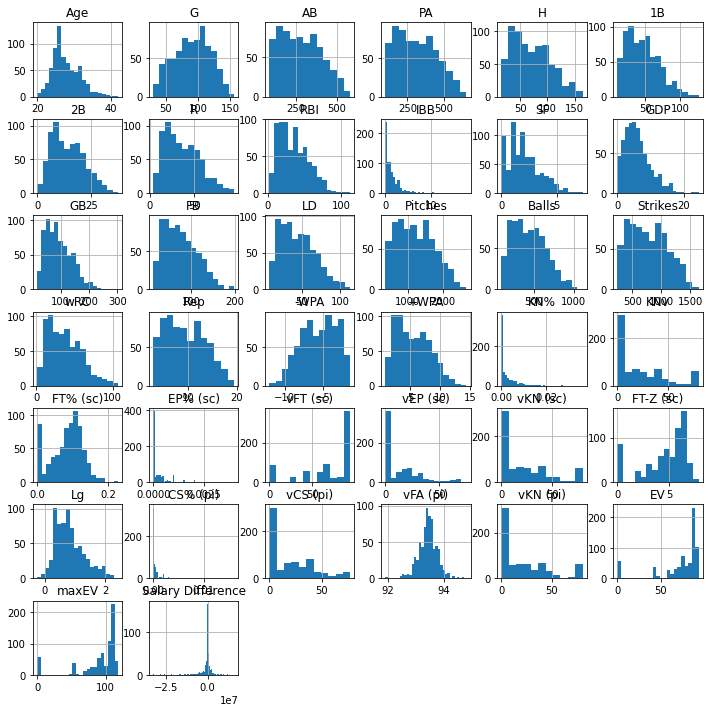

In [153]:
# check distribution of features
X_train.hist(figsize = [12,12], bins = 'auto')
plt.show()

## Preprocessing Pipeline

In [154]:
# define numeric columns to be standard scaled
num_cols = X_train.select_dtypes(['int', 'float']).columns

In [155]:
# define numeric transformation pipeline that scales the numbers
numeric_pipeline = Pipeline([('numnorm', StandardScaler()), # apply a standard scaler
                             ])

In [156]:
# transform the selected columns with numeric pipelines
bat_adv_ct = ColumnTransformer(transformers = [("numpipe", numeric_pipeline, num_cols)])

### Pickle the Transformers

In [158]:
# save the transformer
dump(bat_adv_ct, open('pkl/bat_adv_ct.pkl', 'wb'))

In [159]:
# load the transformer
bat_adv_ct = load(open('pkl/bat_adv_ct.pkl', 'rb'))

**Transform `bat_adv_grouped`**

In [160]:
# inspect the preprocessed batting basic X train aka pp_bb_X_train
pp_X_train = pd.DataFrame(bat_adv_ct.fit_transform(X_train))
pp_X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
0,-0.368508,-0.099997,0.260613,0.229328,0.485390,0.093009,0.668722,0.400218,1.356388,0.913237,0.660053,-0.660992,0.411669,-0.069032,0.125532,0.180217,0.099743,0.227840,0.870285,0.336362,0.032598,0.792019,-0.638508,-0.876409,-1.873871,-0.568190,-2.230506,-0.771150,-0.856236,-2.177255,0.337043,-0.526791,-0.930291,0.229174,-0.854009,0.644349,0.743577,0.195427
1,-1.335337,0.221099,0.564023,0.542806,0.697043,0.492036,0.400301,0.789929,1.305784,0.354239,1.113990,0.148145,-0.120652,0.544612,0.709766,0.508272,0.401971,0.566976,0.962517,0.667292,-0.690026,0.705876,-0.332785,-0.133909,-1.118473,-0.568190,-1.222968,-0.771150,-0.112593,-1.220741,-1.595148,-0.526791,-0.930291,0.324628,-0.112291,0.697564,0.695053,0.176762
2,0.045848,0.705293,0.710634,0.655922,0.460651,0.363518,0.802932,0.418775,0.344309,0.354239,0.951870,0.671347,0.883570,0.556046,0.600623,0.490567,0.267282,0.622849,0.106078,0.705113,-0.851669,0.386957,-0.638508,-0.876409,-0.017963,-0.244123,-0.093272,-0.206434,-0.856236,-0.147743,-0.461464,-0.226232,-0.017120,0.188265,-0.854009,0.560340,0.529148,0.309549
3,-0.092271,1.215608,1.297729,1.327125,1.210543,1.415241,0.886814,1.160154,0.730164,0.354239,0.064259,0.329137,1.787135,1.068211,1.136705,1.256859,1.402483,1.146054,0.985575,1.319845,-1.196226,1.129159,-0.466538,-0.488567,0.151120,-0.001073,0.014968,0.205595,-0.464890,0.016063,0.362921,-0.132308,0.689938,0.837695,-0.008740,0.163896,0.218712,0.753815
4,0.736440,0.375702,0.410220,0.504090,0.201582,-0.255233,0.646353,0.278974,0.892519,1.658568,0.433084,0.105559,-0.488901,1.033749,0.320276,0.662238,0.861882,0.526835,0.632019,0.448051,-0.484495,0.562709,-0.447431,-0.341311,0.590522,0.187966,0.753731,0.531176,-0.321311,0.496280,0.233533,0.174513,1.663743,0.467809,-0.319394,0.104113,0.130021,0.225153


In [161]:
pp_X_train.shape

(710, 38)

Now lets do the same transformation for the `X_test`

In [162]:
# inspect the preprocessed batting basic X train aka pp_bb_X_test
pp_X_test = pd.DataFrame(bat_adv_ct.transform(X_test))
pp_X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
0,-2.025929,-1.277352,-0.825790,-0.920923,-0.697944,-0.712301,-0.270751,-0.690973,-0.819582,-0.484259,-1.382668,-0.149958,-0.178988,-1.176260,-0.638466,-1.063647,-1.070567,-1.042762,-0.812946,-0.854986,0.463994,-0.847729,-0.638508,-0.876409,-1.873871,-0.568190,-2.230506,-0.771150,-0.856236,-2.177255,-2.043692,-0.526791,-0.930291,0.945081,-0.854009,0.494808,0.631972,0.217772
1,-1.059100,0.549332,0.991313,1.060357,0.976040,0.793846,1.205564,1.091305,0.718778,-0.316560,-0.157036,-0.942061,0.372292,0.485916,0.799648,1.262512,1.395708,1.159409,1.239212,1.150450,-0.761780,0.927421,-0.592649,-0.254202,-0.496204,-0.568190,-0.437694,-0.771150,-0.235888,-0.436713,2.490056,-0.316400,-0.359770,-0.171734,-0.216599,0.694870,0.704758,0.097106
2,0.598321,-0.371146,-0.335860,-0.393381,-0.484366,-0.442413,-0.378119,-0.602638,-0.546320,-0.540159,-0.701761,-0.073303,-0.537758,-0.101048,-0.216020,-0.383834,-0.484673,-0.314675,-0.743772,-0.428086,0.347648,-0.682116,0.691388,0.345605,0.966726,-0.114496,0.749298,-0.033485,0.374507,0.889862,0.130023,0.104382,-0.253309,-0.629914,0.372922,-0.167622,-0.193901,0.244258
3,-0.230389,0.549332,0.190982,0.219587,0.242951,0.332425,0.400301,0.249530,-0.293301,-0.092960,-0.020854,-0.379923,-0.043356,-0.106384,0.530001,0.327219,0.400328,0.276317,0.196993,0.291687,-0.120351,0.179798,-0.638508,-0.876409,-0.384016,-0.568190,-0.424073,-0.771150,-0.856236,-0.370855,0.378447,-0.316400,-0.256039,0.687354,-0.854009,0.610803,0.590889,0.190958
4,-1.335337,-1.134643,-0.574114,-0.636170,-0.495911,-0.538180,-0.404961,-0.716954,-0.060522,0.354239,-0.701761,-0.788750,-0.310245,-0.736037,-0.413761,-0.757951,-0.895637,-0.659884,-0.513192,-0.581968,0.548966,-0.645718,-0.638508,-0.876409,-1.873871,-0.568190,-2.230506,-0.771150,-0.856236,-2.177255,-0.491039,-0.526791,-0.930291,3.092801,-0.854009,0.731245,0.568891,0.292326


In [163]:
pp_X_test.shape

(237, 38)

**Log Transforming Salary**

In [164]:
# basic y
log_y_train = np.log(y_train)
log_y_test = np.log(y_test)

## Modeling

In [165]:
# import my helper function to get model results
from functions import *

### Linear Regression

In [166]:
# build pipeline 
steps = [('preprocess', bat_adv_ct), 
         ('model', LinearRegression())]

lin_reg_pipeline = Pipeline(steps)

lin_reg_pipeline.fit(X_train, log_y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'G', 'AB', 'PA', 'H', '1B', '2B', 'R', 'RBI', 'IBB', 'SF', 'GDP',
       'GB', 'FB', 'LD', 'Pitches', 'Balls', 'Strikes', 'wRC', 'Rep', '-WPA',
       '+WPA', 'KN%', 'KNv', 'FT% (sc)', 'EP% (sc)', 'vFT (sc)', 'vEP (sc)',
       'vKN (sc)', 'FT-Z (sc)', 'Lg', 'CS% (pi)', 'vCS (pi)', 'vFA (pi)',
       'vKN (pi)', 'EV', 'maxEV', 'Salary Difference'],
      dtype='object'))])),
                ('model', LinearRegression())])

In [167]:
# instantiate the model
lr_model = Pipeline(steps).steps[1][1]  # gets the class name of the model

# get model results
model_results(lr_model, pp_X_train, log_y_train, pp_X_test, log_y_test)

             LinearRegression() RESULTS
LinearRegression() Training R2:               0.6572
LinearRegression() Test R2:                   0.5664
-------------------------------------------------------
LinearRegression() Cross Validation R2:       0.5726
LinearRegression() Cross Validation RMSE:    3233185
-------------------------------------------------------
LinearRegression() Training RMSE:            5816481
LinearRegression() Test RMSE:                3178664


## PCA

In [168]:
from sklearn.decomposition import PCA

In [169]:
pca = PCA(n_components= 20) # Check out how `n_components` works

X_train_pca = pca.fit_transform(pp_X_train)
X_test_pca = pca.transform(pp_X_test)

In [170]:
lr_pca = LinearRegression()

# get model results
model_results(lr_pca, X_train_pca, log_y_train, X_test_pca, log_y_test)

             LinearRegression() RESULTS
LinearRegression() Training R2:               0.6357
LinearRegression() Test R2:                   0.5428
-------------------------------------------------------
LinearRegression() Cross Validation R2:       0.5918
LinearRegression() Cross Validation RMSE:    3370807
-------------------------------------------------------
LinearRegression() Training RMSE:            6672116
LinearRegression() Test RMSE:                3076564


In [171]:
lr_pca.coef_

array([ 0.19143518,  0.10474694, -0.1046355 , -0.0483422 ,  0.11304926,
        0.15247307,  0.21862818, -0.14450556,  0.10482317, -0.24985307,
       -0.08024172, -0.13850624, -0.00504888,  0.04818451, -0.00492648,
        0.01496451, -0.12418168, -0.13002404,  0.19056378,  0.12802862])

### Support Vector Machine

In [172]:
from sklearn import svm
from sklearn.svm import LinearSVR

In [173]:
# build pipeline 
svm_steps = [('preprocess', bat_adv_ct),
            ('model', svm.SVR())]

svm_pipeline = Pipeline(svm_steps)

# define parameters in the grid
svm_grid = {
            'model__kernel': ['rbf'],
            'model__C': [0.1, 1],
            'model__degree': [2,3]
           }  

# get best R2 score from grid search
svm_model = GridSearchCV(estimator = svm_pipeline,
                         param_grid = svm_grid,
                         scoring = 'r2')


# fit and give me the best params
svm_model.fit(X_train, log_y_train)
display(svm_model.best_params_)
print("Best CV Score:", round(svm_model.best_score_,5))

{'model__C': 1, 'model__degree': 2, 'model__kernel': 'rbf'}

Best CV Score: 0.65044


In [174]:
# instantiate the model
best_model = svm_model.best_estimator_
svm_model = best_model.steps[1][1]  # gets the class name of the model

# get model results
model_results(svm_model, pp_X_train, log_y_train, pp_X_test, log_y_test)

             SVR(C=1, degree=2) RESULTS
SVR(C=1, degree=2) Training R2:               0.7743
SVR(C=1, degree=2) Test R2:                   0.6531
-------------------------------------------------------
SVR(C=1, degree=2) Cross Validation R2:       0.651
SVR(C=1, degree=2) Cross Validation RMSE:    5482475
-------------------------------------------------------
SVR(C=1, degree=2) Training RMSE:            2540822
SVR(C=1, degree=2) Test RMSE:                2956790


### Gradient Boosting Regressor

In [175]:
from sklearn.ensemble import GradientBoostingRegressor

In [176]:
# build pipeline 
ensemble_steps = [('preprocess', bat_adv_ct), 
                  ('model', GradientBoostingRegressor(random_state = 42))]

ensemble_pipeline = Pipeline(ensemble_steps)

# define parameters in the grid
ensemble_grid = {
                'model__learning_rate': [0.1], 
                'model__n_estimators': [30],
                'model__max_depth': [3],
                'model__max_features': [20, 25]
               }  

# get best R2 score from grid search
ensemble_model = GridSearchCV(estimator = ensemble_pipeline,
                         param_grid = ensemble_grid,
                         scoring = 'r2')

# fit and give me the best params
ensemble_model.fit(X_train, log_y_train)
display(ensemble_model.best_params_)
print("Best CV Score:", round(ensemble_model.best_score_,5))

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__max_features': 25,
 'model__n_estimators': 30}

Best CV Score: 0.76461


In [177]:
# instantiate the model
best_model = ensemble_model.best_estimator_
ensemble_model = best_model.steps[1][1]   # gets the class name of the model

# get model results
model_results(ensemble_model, pp_X_train, log_y_train, pp_X_test, log_y_test)

             GradientBoostingRegressor(max_features=25, n_estimators=30, random_state=42) RESULTS
GradientBoostingRegressor(max_features=25, n_estimators=30, random_state=42) Training R2:               0.8606
GradientBoostingRegressor(max_features=25, n_estimators=30, random_state=42) Test R2:                   0.7755
-------------------------------------------------------
GradientBoostingRegressor(max_features=25, n_estimators=30, random_state=42) Cross Validation R2:       0.7647
GradientBoostingRegressor(max_features=25, n_estimators=30, random_state=42) Cross Validation RMSE:    2629197
-------------------------------------------------------
GradientBoostingRegressor(max_features=25, n_estimators=30, random_state=42) Training RMSE:            2398456
GradientBoostingRegressor(max_features=25, n_estimators=30, random_state=42) Test RMSE:                2801424


### Random Forest

In [178]:
from sklearn.ensemble import RandomForestRegressor

In [179]:
# build pipeline 
rfr_steps = [('preprocess', bat_adv_ct), 
            ('model', RandomForestRegressor(random_state = 42))]

rfr_pipeline = Pipeline(rfr_steps)

# define parameters in the grid
rfr_grid = {'model__n_estimators': [120],
            'model__max_depth': [3, 4],
#             'model__min_samples_split': [2],
#             'model__min_samples_leaf': [2],
            'model__max_features': [10]}  

# get best R2 score from grid search
rfr_model = GridSearchCV(estimator = rfr_pipeline,
                           param_grid = rfr_grid,
                           scoring = 'r2')

# fit and give me the best params
rfr_model.fit(X_train, log_y_train)
rfr_model.best_params_
display(rfr_model.best_params_)
print("Best CV Score:", round(rfr_model.best_score_,5))

{'model__max_depth': 4, 'model__max_features': 10, 'model__n_estimators': 120}

Best CV Score: 0.72616


In [180]:
# instantiate the model
best_model = rfr_model.best_estimator_
rfr_model = best_model.steps[1][1]   # gets the class name of the model

# get model results
model_results(rfr_model, pp_X_train, log_y_train, pp_X_test, log_y_test)

             RandomForestRegressor(max_depth=4, max_features=10, n_estimators=120,
                      random_state=42) RESULTS
RandomForestRegressor(max_depth=4, max_features=10, n_estimators=120,
                      random_state=42) Training R2:               0.8067
RandomForestRegressor(max_depth=4, max_features=10, n_estimators=120,
                      random_state=42) Test R2:                   0.7339
-------------------------------------------------------
RandomForestRegressor(max_depth=4, max_features=10, n_estimators=120,
                      random_state=42) Cross Validation R2:       0.7261
RandomForestRegressor(max_depth=4, max_features=10, n_estimators=120,
                      random_state=42) Cross Validation RMSE:    2740841
-------------------------------------------------------
RandomForestRegressor(max_depth=4, max_features=10, n_estimators=120,
                      random_state=42) Training RMSE:            2905408
RandomForestRegressor(max_depth=4, max_feat

### CatBoost

In [181]:
from catboost import CatBoostRegressor

In [182]:
# build pipeline 
cbr_steps = [('preprocess', bat_adv_ct), 
            ('model', CatBoostRegressor(random_state = 42, 
                                        allow_writing_files=False,
                                        verbose = False))]

cbr_pipeline = Pipeline(cbr_steps)

# define parameters in the grid
cbr_grid = {
                'model__learning_rate': [0.1],
                'model__iterations': [250],
                'model__max_depth': [4],
#                 'model__l2_leaf_reg': [0.1, 1, 10]
               }  

# get best R2 score from grid search
cbr_model = GridSearchCV(estimator = cbr_pipeline,
                         param_grid = cbr_grid,
                         scoring = 'r2')

# fit and give me the best params
cbr_model.fit(X_train, log_y_train)
cbr_model.best_params_
display(cbr_model.best_params_)
print("Best CV Score:", round(cbr_model.best_score_,5))

{'model__iterations': 250, 'model__learning_rate': 0.1, 'model__max_depth': 4}

Best CV Score: 0.76994


In [183]:
# instantiate the model
best_model = cbr_model.best_estimator_
cbr_model = best_model.steps[1][1]   # gets the class name of the model

# get model results
model_results(cbr_model, pp_X_train, log_y_train, pp_X_test, log_y_test)

             <catboost.core.CatBoostRegressor object at 0x169a3f190> RESULTS
<catboost.core.CatBoostRegressor object at 0x169a3f190> Training R2:               0.9434
<catboost.core.CatBoostRegressor object at 0x169a3f190> Test R2:                   0.7522
-------------------------------------------------------
<catboost.core.CatBoostRegressor object at 0x169a3f190> Cross Validation R2:       0.77
<catboost.core.CatBoostRegressor object at 0x169a3f190> Cross Validation RMSE:    2469209
-------------------------------------------------------
<catboost.core.CatBoostRegressor object at 0x169a3f190> Training RMSE:            1455791
<catboost.core.CatBoostRegressor object at 0x169a3f190> Test RMSE:                2414406


### XGBoost

In [184]:
import xgboost as xgb
from xgboost import XGBRegressor

In [185]:
# build pipeline 
xgb_steps = [('preprocess', bat_adv_ct), 
            ('model', XGBRegressor())]

xgb_pipeline = Pipeline(xgb_steps)

# define parameters in the grid
xgb_grid = {'model__n_estimators': [100, 120, 130],
            'model__max_depth': [4, 5,6],
            'model__learning_rate': [0.1]}  

# get best R2 score from grid search
xgb_model = GridSearchCV(estimator = xgb_pipeline,
                           param_grid = xgb_grid,
                           scoring = 'r2')

# fit and give me the best params
xgb_model.fit(X_train, log_y_train)
display(xgb_model.best_params_)
print("Best CV Score:", round(xgb_model.best_score_,5))

{'model__learning_rate': 0.1,
 'model__max_depth': 4,
 'model__n_estimators': 130}

Best CV Score: 0.76241


In [186]:
# instantiate the model
best_model = xgb_model.best_estimator_
xgb_model = best_model.steps[1][1]   # gets the class name of the model

# get model results
model_results(xgb_model, pp_X_train, log_y_train, pp_X_test, log_y_test)

             XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=130, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...) RESULTS
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             impor